<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1 
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew. 

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from scipy import stats

%matplotlib inline

### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [202]:
# ANSWER
titanic_csv = '../DATA/titanic_train.csv'
df = pd.read_csv(filepath_or_buffer = titanic_csv, index_col = 'PassengerId')

Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary 

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

Explore dataset. Find features to predict `Survived`. Get rid of null values. 

In [3]:
# ANSWER
df.shape

(891, 11)

In [5]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df.tail()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


### Fill missing values

#### Tests to use mode rather than average

In [8]:
df[(df.Pclass == 3)&(df.Sex == 'female')].isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age          42
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       138
Embarked      0
dtype: int64

In [11]:
df[(df.Sex == 'female') & (df.Pclass == 3)].count()

Survived    144
Pclass      144
Name        144
Sex         144
Age         102
SibSp       144
Parch       144
Ticket      144
Fare        144
Cabin         6
Embarked    144
dtype: int64

In [30]:
df.groupby(['Sex','Pclass']).Age.agg(stats.mode)

Sex     Pclass
female  1          ([35.0], [6])
        2          ([24.0], [7])
        3          ([18.0], [8])
male    1          ([36.0], [6])
        2          ([23.0], [6])
        3         ([22.0], [14])
Name: Age, dtype: object

In [21]:
#teset - predict missing age using mode rather than mean
df.groupby(['Sex','Pclass']).Age.agg(lambda x: stats.mode(x)[0][0])

Sex     Pclass
female  1         35.0
        2         24.0
        3         18.0
male    1         36.0
        2         23.0
        3         22.0
Name: Age, dtype: float64

In [42]:
df_mode = df.copy()
df_mode.Age.fillna(df_mode.groupby(['Sex','Pclass']).Age.transform(lambda x: stats.mode(x)[0][0]), inplace = True)

In [43]:
df_mode.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

#### Fill missing age with median

In [44]:
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [54]:
#transform dataframe substituting missing value based on median of age grouped by Sex and Pclass
df.Age.fillna(df.groupby(['Sex','Pclass']).Age.transform("median"), inplace = True)

#### Fill missing Embarked values

In [94]:
#identify observations with missing values
df[df.Embarked.isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [95]:
#based on information available on the internet I'll assume they embarked in Southhampton
df.Embarked.fillna(value='S', inplace=True)

### Visulization

#### Visualize some of the data

In [59]:
def bar_chart(dataframe, feature):
    survived = dataframe[dataframe['Survived']==1][feature].value_counts(normalize = True)*100
    dead = dataframe[dataframe['Survived']==0][feature].value_counts(normalize = True)*100
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar',stacked=True, figsize=(10,5), title = 'Surval by Sex percentage')

In [60]:
df.Sex[df.Survived == 1].value_counts()

female    233
male      109
Name: Sex, dtype: int64

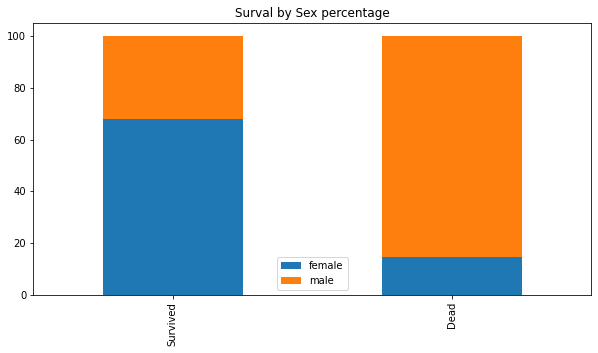

In [61]:
# Sex
bar_chart(df, 'Sex')

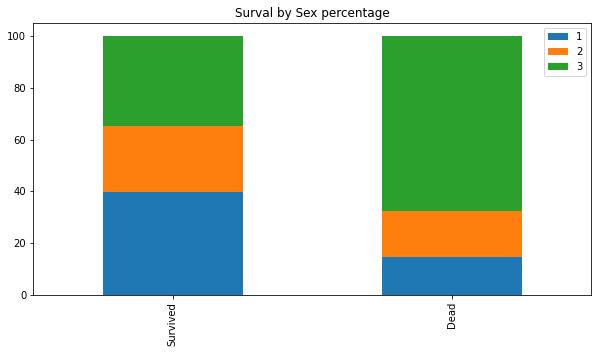

In [62]:
bar_chart(df, 'Pclass')

In [90]:
def facetplot(dataframe, feature, hue = "Survived"):
    facet = sns.FacetGrid(dataframe, hue=hue, aspect=4)
    facet.map(sns.kdeplot, feature, shade= True)
    facet.set(xlim=(0, dataframe[feature].max()))
    facet.add_legend()
    plt.show()

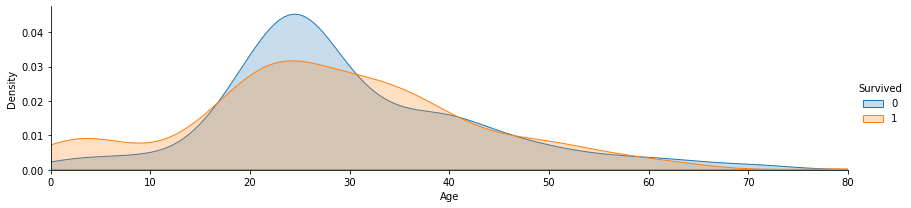

In [91]:
facetplot(df, 'Age')

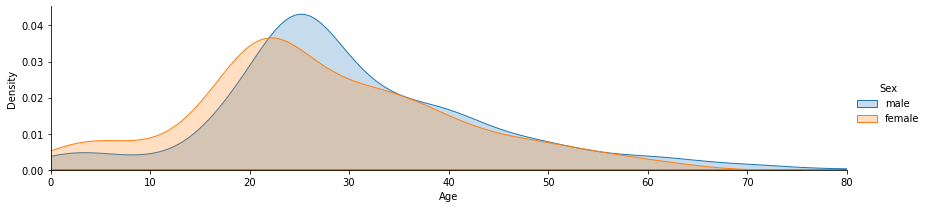

In [92]:
facetplot(df, 'Age', 'Sex')

### 3. Numerical Predictors Only

#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [129]:
# ANSWER
features = ['Pclass', 'Parch']
X = df[features]
y = df['Survived']

#### 3.2 Partition

Partition the data into training and testing subsets:

- Use `random_state` = 1

In [98]:
# ANSWER As test_size and train_size is none the split will be 75% train and 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [103]:
# ANSWER
# Create Model
logreg = LogisticRegression()

Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [108]:
# ANSWER
# Fit Model
logreg.fit(X_train, y_train)

LogisticRegression()

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [106]:
# ANSWER
logreg.coef_

array([[-0.87239066,  0.337888  ]])

The computed intercept (`intercept_`) is the 1st element of another array:

In [110]:
# ANSWER
logreg.intercept_

array([1.30430282])

We can create tuples of the predictor names and coefficients like this:

In [114]:
# ANSWER
print(set(zip(features, logreg.coef_[0])))

{('Pclass', -0.872390660601778), ('Parch', 0.33788800487797466)}


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [116]:
for col in zip(X_train.columns, logreg.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

Pclass      -0.872391
Parch       +0.337888


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The `accuracy_score` is the proportion of correct predictions:

In [118]:
# ANSWER
logreg.score(X_train, y_train).round(4)

0.6901

What is the  `accuracy_score` for the test data?

In [121]:
# ANSWER
logreg.score(X_test, y_test).round(4)

0.6682

What can we say aout this result?

ANSWER
- my test scores vs train score show the model is slightly less accurate on unknown data ~3%
- my scores doesn't seem to show signs of overfitting to the test data

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

In [130]:
# Add feature
features += ["Age"]
# Assign two new variables with the dataframe containing the added column
X = df[features]
# Target
y = df['Survived']
# Assign two new dataframes (test and train)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [133]:
# Build Model
logreg = LogisticRegression()
# Fit Model
logreg.fit(X_train, y_train)
# Score
print(logreg.score(X_train, y_train))
print(logreg.score(X_test, y_test))

0.7155688622754491
0.672645739910314


So, including age did little to reduce the variance in our model. Why might this be?

ANSWER

- Age might not be independent from other features already used. This would align with what we see when using mode or median and passenger class as we see more people from 1st class survived who also have a higher age
- Age might not be related to survival
- we use imputed values for quite a substantial part of the age feature

Let's see where the model is going wrong by showing the Confusion Matrix:

In [137]:
# ANSWER
y_pred_class = logreg.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[105  23]
 [ 50  45]]


Nb. Here is how `confusion_matrix` arranges its output:

In [138]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


Which type of error is more prevalent?

ANSWER: Type 2 error False Negative

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

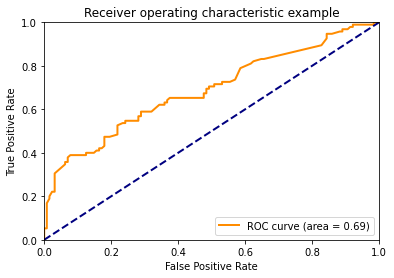

In [139]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [218]:
titanic_with_dummies = pd.get_dummies(data = df, columns = ['Sex', 'Embarked', 'Pclass'], 
                                      prefix = ['Sex', 'Embarked', 'Pclass'] )
titanic_with_dummies.head()

,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,1,0,0,1,0,0,1
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0,1,0,0,1,0,0
3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,0,0,0,1,0,0,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,0,0,0,1,1,0,0
5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,1,0,0,1,0,0,1


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first vriable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [222]:
titanic_with_dummies['Age'] = titanic_with_dummies[["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2"]].groupby(["Parch", "Sex_male", "Pclass_1", "Pclass_2"])["Age"].transform(lambda x: x.fillna(x.mean()))

Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [235]:
#create data frames with predictors and target
X = titanic_with_dummies[['Parch', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age', 'SibSp']]
y = titanic_with_dummies['Survived']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

# Build Model
logreg = LogisticRegression()

# Fit model
logreg.fit(X_train, y_train)

# Score model
logreg_score = logreg.score(X_test, y_test)

In [236]:
logreg_score

0.6636771300448431

Plot the ROC curve for the new model:

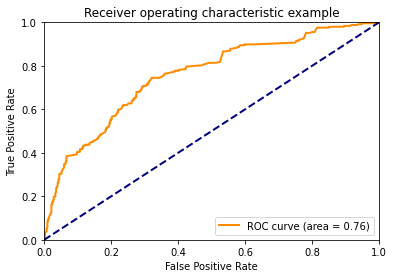

In [237]:
# ANSWER
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_train)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_train, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

Can we improve the model by including the remaining features?

In [238]:
X = titanic_with_dummies.drop(['Survived', 'Name', 'Ticket', 'Cabin'], axis = 1)
y = titanic_with_dummies['Survived']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

# Build Model
logreg = LogisticRegression(max_iter = 1000)

# Fit data to model
logreg.fit(X_train, y_train)

# Score
logreg.score(X_test, y_test)

0.8071748878923767

In [239]:
X = titanic_with_dummies.drop(['Survived', 'Name', 'Ticket', 'Cabin'], axis = 1)
y = titanic_with_dummies['Survived']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

# Build Model
logreg = LogisticRegression(max_iter= 2000)

# Fit
logreg.fit(X_train, y_train)

# Make a data frame of results, including actual and predicted response:
y_hat = logreg.predict(X)
y_hats = pd.Series(y_hat, index = X.index)
y_hatdf = pd.DataFrame({'y_hat': y_hats})
y_actuals = pd.Series(y, index = X.index)    # names 'y', 'y_test' are in use
y_actualdf = pd.DataFrame({'y_actual': y_actuals})   
ttall = y_hatdf.join(y_actualdf).join(X)
ttall.head()

,y_hat,y_actual,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,,,
1,0,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
2,1,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
3,1,1,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
4,1,1,35.0,1,0,53.1000,1,0,0,0,1,1,0,0
5,0,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1


In [240]:
print("Male survival: {:5.2f}% of {}\nFemale survival: {:5.2f}% of {}\nChild survival: {:5.2f}% of {}".format(
                                                    100 * ttall[ttall.Sex_male == 1].y_hat.mean(), ttall.Sex_male.sum(), 
                                                    100 * ttall[ttall.Sex_female == 1].y_hat.mean(), ttall.Sex_female.sum(),
                                                    100 * ttall[ttall.Age < 16].y_hat.mean(), len(ttall[ttall.Age < 16])))

Male survival:  5.20% of 577
Female survival: 85.67% of 314
Child survival: 45.10% of 102


## Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.



---



---



> > > > > > > > > © 2021 Institute of Data


---



---



